# Notebook 1: Introducción al aprendizaje por refuerzos

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

Facultad de Matemática, Astronomía, Física y Computación, Universidad Nacional de Córdoba

Grupo 8. Integrantes:


*   Grisel Britos
*   Miqueas Morosin



## Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos, los cuáles son necesarios para realizar este Lab.

In [ ]:
# @title Código básico importacion y utilerías (no modificar)

import itertools
from typing import Any, Callable, Tuple

import numpy as np
import matplotlib.pyplot as plt


def plot_reward_per_episode(reward_ep) -> None:
    episode_rewards = np.array(reward_ep)

    # se suaviza la curva de convergencia
    episode_number = np.linspace(
        1, len(episode_rewards) + 1, len(episode_rewards) + 1)
    acumulated_rewards = np.cumsum(episode_rewards)

    reward_per_episode = [
        acumulated_rewards[i] / episode_number[i]
        for i in range(len(acumulated_rewards))
    ]

    plt.plot(reward_per_episode)
    plt.title("Recompensa acumulada por episodio")
    plt.show()


def plot_steps_per_episode(timesteps_ep) -> None:
    # se muestra la curva de aprendizaje de los pasos por episodio
    episode_steps = np.array(timesteps_ep)
    plt.plot(np.array(range(0, len(episode_steps))), episode_steps)
    plt.title("Pasos (timesteps) por episodio")
    plt.show()


def plot_steps_per_episode_smooth(timesteps_ep) -> None:
    episode_steps = np.array(timesteps_ep)

    # se suaviza la curva de aprendizaje
    episode_number = np.linspace(
        1, len(episode_steps) + 1, len(episode_steps) + 1)
    acumulated_steps = np.cumsum(episode_steps)

    steps_per_episode = [
        acumulated_steps[i] / episode_number[i] for i in range(
            len(acumulated_steps))
    ]

    plt.plot(steps_per_episode)
    plt.title("Pasos (timesteps) acumulados por episodio")
    plt.show()


def draw_value_matrix(q) -> None:
    n_rows = 4
    n_columns = 12
    n_actions = 4

    # se procede con los cálculos previos a la graficación de la matriz de valor
    q_value_matrix = np.empty((n_rows, n_columns))
    for row in range(n_rows):
        for column in range(n_columns):
            state_values = []

            for action in range(n_actions):
                state_values.append(
                    q.get((row * n_columns + column, action), -100))

            maximum_value = max(
                state_values
            )  # determinamos la acción que arroja máximo valor

            q_value_matrix[row, column] = maximum_value

    # el valor del estado objetivo se asigna en -1 (reward recibido al llegar)
    # para que se coloree de forma apropiada
    q_value_matrix[3, 11] = -1

    # se grafica la matriz de valor
    plt.imshow(q_value_matrix, cmap=plt.cm.RdYlGn)
    plt.tight_layout()
    plt.colorbar()

    for row, column in itertools.product(
        range(q_value_matrix.shape[0]), range(q_value_matrix.shape[1])
    ):
        left_action = q.get((row * n_columns + column, 3), -1000)
        down_action = q.get((row * n_columns + column, 2), -1000)
        right_action = q.get((row * n_columns + column, 1), -1000)
        up_action = q.get((row * n_columns + column, 0), -1000)

        arrow_direction = "D"
        best_action = down_action

        if best_action < right_action:
            arrow_direction = "R"
            best_action = right_action
        if best_action < left_action:
            arrow_direction = "L"
            best_action = left_action
        if best_action < up_action:
            arrow_direction = "U"
            best_action = up_action
        if best_action == -1:
            arrow_direction = ""

        # notar que column, row están invertidos en orden en la línea de abajo
        # porque representan a x,y del plot
        plt.text(column, row, arrow_direction, horizontalalignment="center")

    plt.xticks([])
    plt.yticks([])
    plt.show()

    print("\n Matriz de mejor acción-valor (en números): \n\n", q_value_matrix)

## Actividades

1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".

2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.

3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

4. (Opcional) Implementar política de exploración Softmax, en donde cada acción tiene una probabilidad $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

5. (Opcional) Implementar Dyna-Q a partir del algoritmo Q-Learning, incorporando una actualización mediante un modelo. Comentar cómo se desempeña respecto a los demás algoritmos.


Para dejar el lab listo para su corrección, dejar link a repo de Github con un notebook ejecutando el agente en la planilla enviada en Slack.

![](https://github.com/GIDISIA/RLDiplodatos/blob/master/images/cliffwalking.png?raw=1)

donde S= starting point, G= goal

(imagen de Sutton y Barto, 2018)

Descripción del entorno:

Acciones:

* $\uparrow$ - Arriba
* $\downarrow$ - Abajo
* $\rightarrow$ - Derecha
* $\leftarrow$ - Izquierda

Función de recompensa:

* $-1$ en todos los demás estados
* $-100$ en el acantilado

Nota: caer en el acantilado devuelve al agente al estado inicial en un mismo episodio

## 1. Implementación algoritmo SARSA

Importamos las librerías

In [ ]:
import gymnasium as gym
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

Definimos el método de elección de acciones. En este caso el mismo utiliza la política de exploración $\epsilon$-greedy.

In [ ]:
def choose_action_e_greedy(
        state: int,
        actions: range,
        q: dict,
        hyperparameters: dict,
        random_state: np.random.RandomState,
) -> int:
    """
    Elije una acción de acuerdo al aprendizaje realizado previamente
    usando una política de exploración épsilon-greedy
    """
    # ej: para 4 acciones inicializa en [0,0,0,0]
    q_values = [q.get((state, a), 0.0) for a in actions]
    max_q = max(q_values)
    # Exploración
    # sorteamos un número: es menor a épsilon?
    if random_state.uniform() < hyperparameters['epsilon']:
        # sí: se selecciona una acción aleatoria
        return random_state.choice(actions)

    count = q_values.count(max_q)

    # Explotación (resuelve empates)
    # hay más de un máximo valor de estado-acción?

    if count > 1:
        # sí: seleccionamos uno de ellos aleatoriamente
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        # no: seleccionamos el máximo valor de estado-acción
        i = q_values.index(max_q)

    return actions[i]



In [ ]:
# --- Función SARSA ---
def learn_SARSA(state, action, reward, next_state, next_action, hyperparameters, q):
    """
    Actualiza la tabla Q según la regla SARSA
    Args:
        state:  estado actual (por ejemplo, una tupla (fila, columna))
        action:  acción tomada en el estado actual (↑, ↓, →, ←)
        reward:  recompensa recibida tras ejecutar la acción
        next_state:  estado siguiente
        next_action:  acción elegida en el estado siguiente (según política ε-greedy)
        hyperparameters:  diccionario con parámetros
        q:  diccionario con los valores Q
    """
    alpha = hyperparameters['alpha']
    gamma = hyperparameters['gamma']
    current_q = q.get((state, action), 0.0)
    next_q = q.get((next_state, next_action), 0.0)
    q[(state, action)] = current_q + alpha * (reward + gamma * next_q - current_q)



Definimos la función general `run` que luego será entrenada usando el algoritmo SARSA (también se puede usar con Q-learning

In [ ]:
# --- Entrenamiento SARSA ---
def run(
    learning_function: Callable,
    hyperparameters: dict,
    episodes_to_run: int,
    env: gym.Env,
    actions: range,
    q: dict,
    random_state: np.random.RandomState,
) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Corre el algoritmo de RL para el ambiente FrozenLake-v0.
    Args:
        learning_function: función de actualización de algoritmo de aprendizaje
        hyperparameters: hiperparámetros del algoritmo de aprendizaje
        episodes_to_run: cantidad de episodios a ejecutar
        env: ambiente de Gymnasium
        actions: lista de acciones posibles
        q: diccionario de valores de estado-acción
        random_state: generador de números aleatorios
    """
    # registro de la cantidad de pasos que le llevó en cada episodio
    # llegar a la salida
    timesteps_of_episode = []
    # cantidad de recompensa que recibió el agente en cada episodio
    reward_of_episode = []

    for _ in range(episodes_to_run):
        # se ejecuta una instancia del agente hasta que el mismo
        # llega a la salida o tarda más de 2000 pasos

        # reinicia el ambiente, obteniendo el estado inicial del mismo
        state, _ = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # elige una acción basado en el estado actual.
        # Filtra el primer elemento de state, que es el estado en sí mismo
        action = choose_action_e_greedy(
            state, actions, q, hyperparameters, random_state)

        while not done:
            # el agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, terminated, truncated, _ = env.step(action)

            next_action = choose_action_e_greedy(
                next_state, actions, q, hyperparameters, random_state)

            episode_reward += reward
            learning_function(
                state,
                action,
                reward,
                next_state,
                next_action,
                hyperparameters,
                q
            )

            done = terminated or truncated

            # if the algorithm does not converge, it stops after 2000 timesteps
            if not done and t < 2000:
                state = next_state
                action = next_action
            else:
                # el algoritmo no ha podido llegar a la meta antes de dar 2000 pasos
                done = True  # se establece manualmente la bandera done
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(
                    reward_of_episode, max(episode_reward, -100)
                )

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

Procedemos a instanciar a nuestro agente.

In [ ]:
q = {}

hyperparameters = {
    "alpha": 0.5,
    "gamma": 1,
    "epsilon": 0.1,
    "tau": 25,
}

learning_function = learn_SARSA
episodes_to_run = 500

env = gym.make("CliffWalking-v1")
actions = range(env.action_space.n)

random_state = np.random.RandomState(42)

Ya instanciado, ejecutamos nuestro agente

In [ ]:
avg_steps_per_episode, timesteps_ep, reward_ep = run(
    learning_function,
    hyperparameters,
    episodes_to_run,
    env,
    actions,
    q,
    random_state
)

### Análisis de la ejecución del agente



Para analizar la ejecución del agente, vamos a ver cómo se desempeñó el mismo en dos curvas:

* Recompensa obtenida en cada episodio: nos dirá cuánta recompensa obtuvo el agente sumando cada una de recompensas individuales de cada episodio. Con esta medida podremos tener una noción de cómo se desempeñó esquivando el acantilado y llegando lo antes posible a la meta.

* Pasos transcurridos en cada episodio: indicará cuántos pasos le ha llevado al agente la ejecución del episodio.


Procedemos a probar el algoritmo con diferentes valores de `alpha`, `epsilon` y `gamma`.

In [ ]:
param_sets = [
    {"alpha": 0.1, "epsilon": 0.1, "gamma": 0.95},
    {"alpha": 0.5, "epsilon": 0.1, "gamma": 0.95},
    {"alpha": 0.9, "epsilon": 0.1, "gamma": 0.95},

    {"alpha": 0.5, "epsilon": 0.3, "gamma": 0.95},
    {"alpha": 0.5, "epsilon": 0.05, "gamma": 0.95},

    {"alpha": 0.5, "epsilon": 0.1, "gamma": 0.8},
    {"alpha": 0.5, "epsilon": 0.1, "gamma": 0.999},
]


In [ ]:
def plot_reward_per_episode(reward_ep, ax) -> None:
    episode_rewards = np.array(reward_ep)

    episode_number = np.linspace(
        1, len(episode_rewards) + 1, len(episode_rewards) + 1
    )
    acumulated_rewards = np.cumsum(episode_rewards)

    reward_per_episode = [
        acumulated_rewards[i] / episode_number[i]
        for i in range(len(acumulated_rewards))
    ]

    ax.plot(reward_per_episode)
    ax.set_title("Recompensa acumulada por episodio")
    ax.set_xlabel("Episodio")
    ax.set_ylabel("Reward")


def plot_steps_per_episode(timesteps_ep, ax) -> None:
    episode_steps = np.array(timesteps_ep)

    ax.plot(range(len(episode_steps)), episode_steps)
    ax.set_title("Pasos por episodio")
    ax.set_xlabel("Episodio")
    ax.set_ylabel("Timesteps")


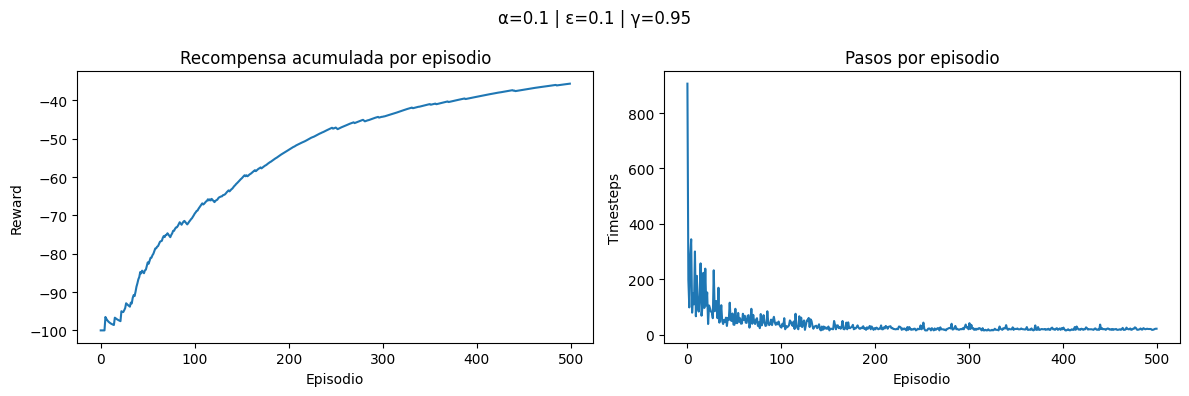

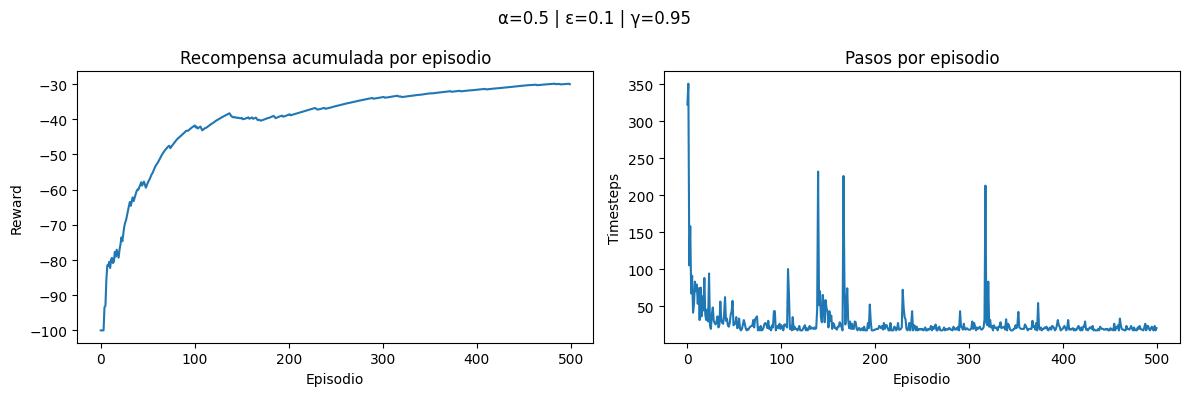

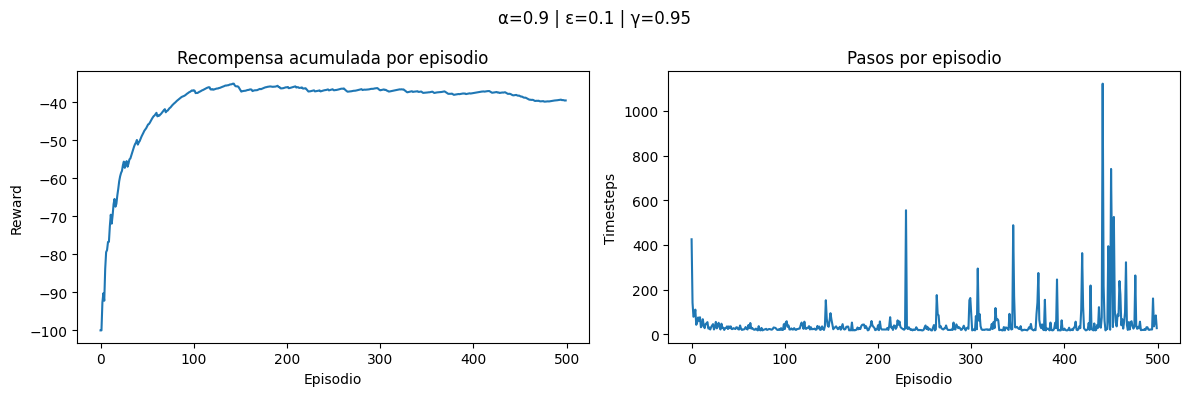

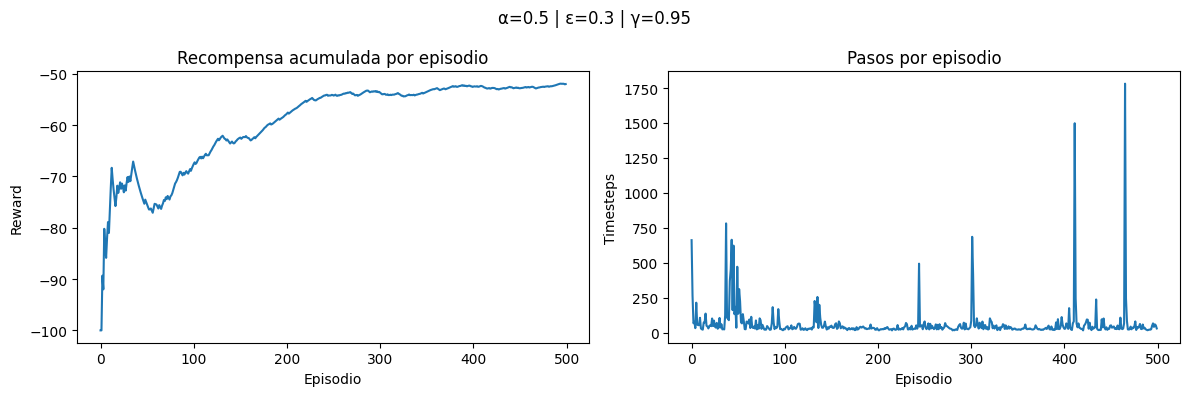

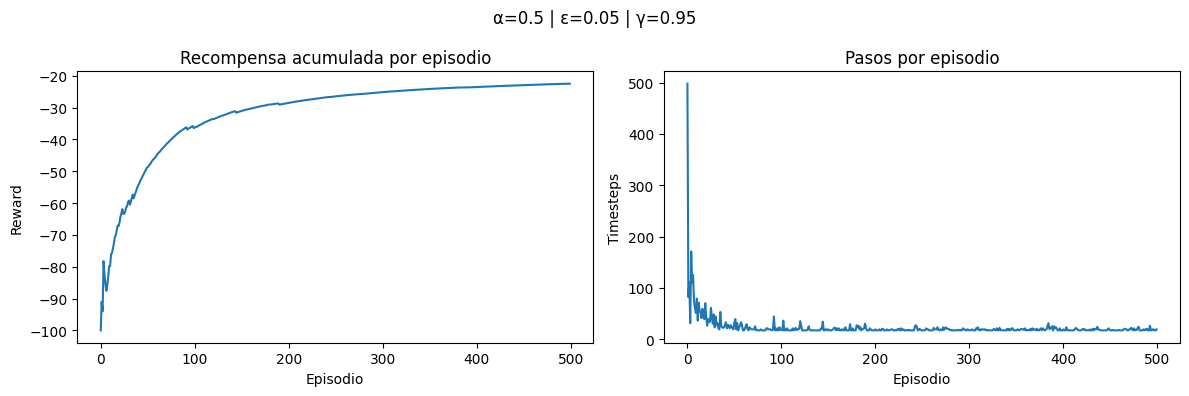

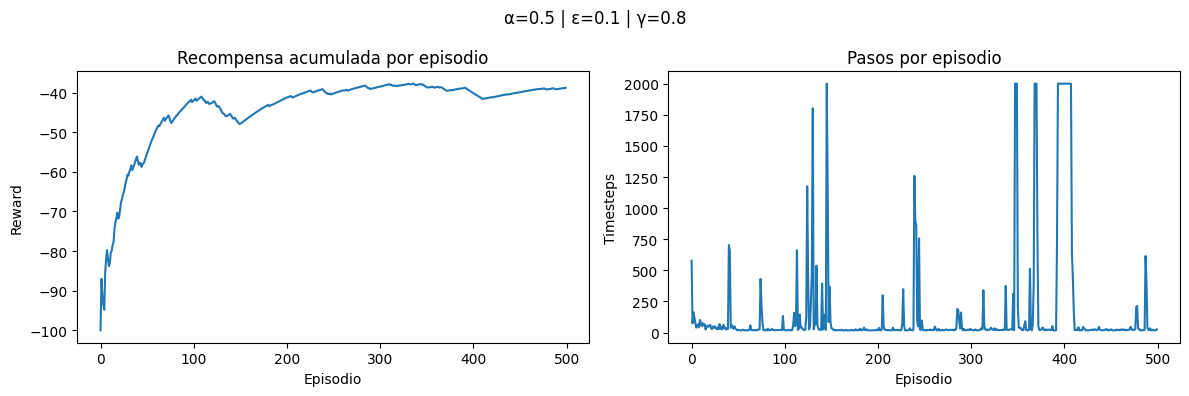

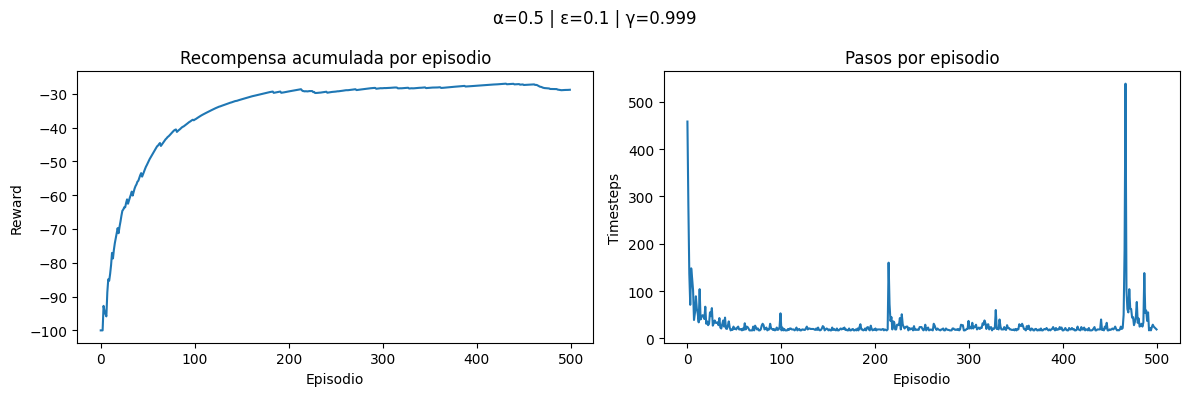

In [ ]:
for idx, params in enumerate(param_sets):

    q = {}  # reiniciar Q-table
    avg, timesteps_ep, reward_ep = run(
        learning_function,
        params,
        episodes_to_run,
        env,
        actions,
        q,
        random_state
    )

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    plot_reward_per_episode(reward_ep, axes[0])
    plot_steps_per_episode(timesteps_ep, axes[1])

    fig.suptitle(f"α={params['alpha']} | ε={params['epsilon']} | γ={params['gamma']}")
    plt.tight_layout()
    plt.show()


Cuando $\alpha$ aumenta, cada actualización de la tabla Q incorpora más peso de la experiencia reciente. Esto hace que el aprendizaje sea más rápido y que la recompensa mejore en menos episodios, es decir, la convergencia se acelera. El agente aprende más rápido a evitar caerse del acantilado y a dirigirse hacia la meta. Sin embargo, también puede volver su comportamiento más inestable: pequeños errores pueden modificar mucho la política, por lo que el número de pasos por episodio puede volverse errático, reflejando trayectorias donde el agente a veces se arriesga de más.

Para un valor fijo de $\alpha=0.5$, al disminuir $\epsilon$ el agente explora menos y se apoya más en lo aprendido. Como consecuencia, la recompensa acumulada aumenta de forma más sostenida y los pasos por episodio muestran una evolución más estable, ya que el comportamiento es menos aleatorio. El agente deja de probar caminos nuevos y arriesgados (que podrían llevarlo al acantilado) y se concentra en seguir la ruta segura ya conocida, la cual evita caídas y reduce variaciones en la longitud de los episodios.


Finalmente, para $\alpha=0.5$ y $\epsilon=0.1$, cuando $\gamma$ aumenta el agente le da más importancia a las recompensas futuras. Eso implica valorar trayectorias más cortas y seguras hacia la meta y penalizar acciones que puedan acercarlo al borde del acantilado, incluso si en el corto plazo parecen convenientes.
Esto se traduce en una convergencia más estable de la recompensa y en curvas de pasos por episodio con menos oscilaciones: el agente planifica mejor y evita tomar atajos que podrían terminar en una caída.


In [ ]:
env.close()

## 2. Implementación algoritmo Q-Learning (off-policy)

In [ ]:
# completar argumentos de la función para hacer una actualización Q-learning
def learn_Q_learning(
    state: int,
    action: int,
    reward: float,
    next_state: int,
    next_action_ignored: int,
    hyperparameters: dict,
    q: dict,
) -> None:
    """
    Realiza una actualización según Q-Learning (off-policy) para una transición (s,a,r,s').
    Requiere: hyperparameters["alpha"], hyperparameters["gamma"], hyperparameters["actions"].

    Args:
        state: estado s actual.
        action: acción a tomada en s.
        reward: recompensa r observada.
        next_state: estado s' alcanzado.
        next_action_ignored: no se usa en Q-Learning (mantiene la firma común).
        hyperparameters: diccionario con 'alpha', 'gamma' y 'actions' (lista/range de acciones).
        q: diccionario Q[(s,a)] -> valor.
    """
    alpha = float(hyperparameters["alpha"])
    gamma = float(hyperparameters["gamma"])
    actions = hyperparameters.get("actions")
    if actions is None:
        # Importante para que Q-Learning pueda calcular max_a' Q(s',a')
        raise ValueError("Falta hyperparameters['actions'] = list(actions) antes de run().")

    sa = (state, action)
    q_sa = q.get(sa, 0.0)

    # max_a' Q(s',a') con 0.0 por defecto si (s',a') aún no fue visto
    max_next = max((q.get((next_state, a), 0.0) for a in actions), default=0.0)

    target = reward + gamma * max_next
    q[sa] = q_sa + alpha * (target - q_sa)

Definimos nuevamente la función general run que luego será entrenada usando el algoritmo Q-learning.

In [ ]:
def run(
    learning_function: Callable,
    hyperparameters: dict,
    episodes_to_run: int,
    env: gym.Env,
    actions: range,
    q: dict,
    random_state: np.random.RandomState,
) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Corre el algoritmo de RL para el ambiente FrozenLake-v0.
    Args:
        learning_function: función de actualización de algoritmo de aprendizaje
        hyperparameters: hiperparámetros del algoritmo de aprendizaje
        episodes_to_run: cantidad de episodios a ejecutar
        env: ambiente de Gymnasium
        actions: lista de acciones posibles
        q: diccionario de valores de estado-acción
        random_state: generador de números aleatorios
    """
    # registro de la cantidad de pasos que le llevó en cada episodio
    # llegar a la salida
    timesteps_of_episode = []
    # cantidad de recompensa que recibió el agente en cada episodio
    reward_of_episode = []

    for _ in range(episodes_to_run):
        # se ejecuta una instancia del agente hasta que el mismo
        # llega a la salida o tarda más de 2000 pasos

        # reinicia el ambiente, obteniendo el estado inicial del mismo
        state, _ = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # elige una acción basado en el estado actual.
        # Filtra el primer elemento de state, que es el estado en sí mismo
        action = choose_action_e_greedy(
            state, actions, q, hyperparameters, random_state)

        while not done:
            # el agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, terminated, truncated, _ = env.step(action)

            next_action = choose_action_e_greedy(
                next_state, actions, q, hyperparameters, random_state)

            episode_reward += reward
            learning_function(
                state,
                action,
                reward,
                next_state,
                next_action,
                hyperparameters,
                q
            )

            done = terminated or truncated

            # if the algorithm does not converge, it stops after 2000 timesteps
            if not done and t < 2000:
                state = next_state
                action = next_action
            else:
                # el algoritmo no ha podido llegar a la meta antes de dar 2000 pasos
                done = True  # se establece manualmente la bandera done
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(
                    reward_of_episode, max(episode_reward, -100)
                )

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

Definidos los métodos básicos, procedemos a instanciar a nuestro agente.

In [ ]:
# Entorno y acciones (v1)
env = gym.make("CliffWalking-v1")
actions = range(env.action_space.n)

# Q-table
q = {}

# Hiperparámetros
hyperparameters = {
    "alpha": 0.5,
    "gamma": 1.0,
    "epsilon": 0.1,
    "tau": 25,
}
hyperparameters["actions"] = list(actions)

# Semilla y episodios
random_state = np.random.RandomState(42)
episodes_to_run = 500
env.reset(seed=42)

# Elegir algoritmo y ejecutar
learning_function = learn_Q_learning

Ya instanciado, ejecutamos nuestro agente

In [ ]:
avg_reward_per_episode, timesteps_ep, rewards_ep = run(
    learning_function,
    hyperparameters,
    episodes_to_run,
    env,
    actions,
    q,
    random_state
)

### Análisis de la ejecución del agente



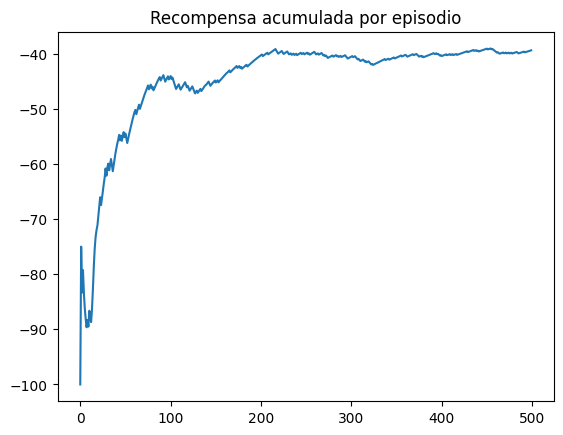

In [ ]:
plot_reward_per_episode(rewards_ep)

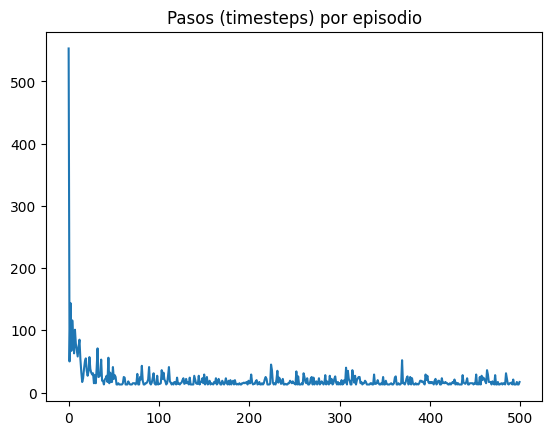

In [ ]:
plot_steps_per_episode(timesteps_ep)

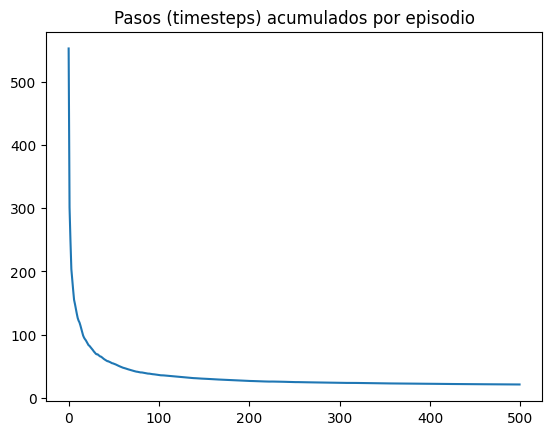

In [ ]:
plot_steps_per_episode_smooth(timesteps_ep)

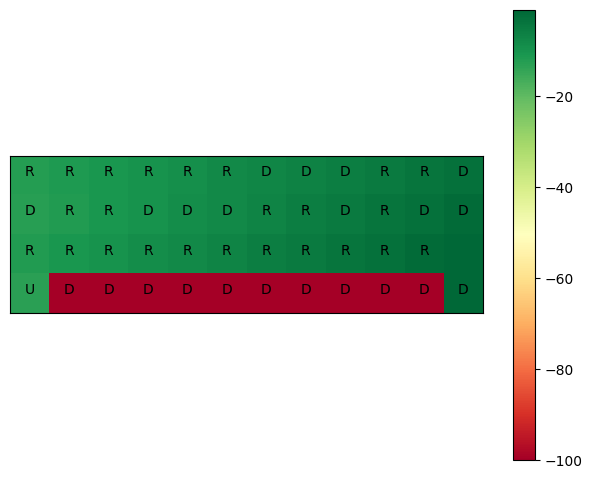


 Matriz de mejor acción-valor (en números): 

 [[ -12.3189387   -11.59140422  -10.84866451   -9.96310256   -9.18688713
    -8.34095048   -7.4542462    -6.72926453   -5.82792094   -4.91990551
    -3.95712468   -2.99947958]
 [ -12.87149892  -11.96404923  -10.98713428   -9.99742173   -8.99937844
    -7.99976186   -6.99991029   -5.99997592   -4.99999754   -3.99999928
    -2.99999988   -2.        ]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [ ]:
draw_value_matrix(q)

Con α=0.5, γ=1.0 y ε=0.1 el agente Q-Learning aprendió rápido una ruta corta pero riesgosa; los pasos se estabilizan bajos, pero la recompensa media (~−40) queda lastrada por caídas esporádicas al acantilado.

En el experimento con CliffWalking-v1, se observó que la recompensa acumulada crece con fuerza al inicio y se estabiliza alrededor de −40, mientras que los pasos por episodio caen rápidamente y permanecen bajos. La matriz de acción-valor y la política resultante muestran decisiones que se “pegan” al borde del acantilado: el agente prioriza trayectorias cortas incluso si eso implica un riesgo residual. Este patrón es coherente con la naturaleza off-policy de Q-Learning: al actualizar con el máximo sobre
𝑄
(
𝑠
′
,
𝑎
′
), el algoritmo evalúa el futuro como si siempre fuese greedy, lo que empuja hacia la ruta óptima en longitud aunque no sea la más segura durante el entrenamiento.

En suma, el entrenamiento converge: el agente estabiliza trayectorias cortas y consistentes, pero la recompensa media queda limitada por un riesgo residual de caída asociado a mantener la exploración fija (ε=0.1). Con α=0.5 y γ=1.0 se privilegia un aprendizaje veloz y una planificación de largo plazo; aun así, esa pequeña tasa de exploración permite fallos puntuales que deprimen el promedio. El patrón es coherente con el carácter off-policy de Q-Learning, que favorece la ruta más corta aunque no siempre la más segura; de allí el costo de seguridad imperfecta observado.

Procedemos a probar el algoritmo con diferentes valores de `alpha`, `epsilon` y `gamma`, de la misma manera que se realizo anteriormente para SARSA.

In [ ]:
param_sets = [
    {"alpha": 0.1, "epsilon": 0.1, "gamma": 0.95},
    {"alpha": 0.5, "epsilon": 0.1, "gamma": 0.95},
    {"alpha": 0.9, "epsilon": 0.1, "gamma": 0.95},
    {"alpha": 0.5, "epsilon": 0.3, "gamma": 0.95},
    {"alpha": 0.5, "epsilon": 0.05, "gamma": 0.95},
    {"alpha": 0.5, "epsilon": 0.1, "gamma": 0.8},
    {"alpha": 0.5, "epsilon": 0.1, "gamma": 0.999},
]

In [ ]:
def plot_reward_per_episode_avg(reward_ep, ax) -> None:
    episode_rewards = np.array(reward_ep, dtype=float)
    episode_number = np.arange(1, len(episode_rewards) + 1, dtype=float)
    acumulated_rewards = np.cumsum(episode_rewards)
    reward_per_episode = acumulated_rewards / episode_number
    ax.plot(reward_per_episode)  # promedio acumulado
    ax.set_title("Recompensa acumulada por episodio")
    ax.set_xlabel("Episodio")
    ax.set_ylabel("Reward")

def plot_steps_per_episode_line(timesteps_ep, ax) -> None:
    episode_steps = np.array(timesteps_ep, dtype=float)
    ax.plot(range(len(episode_steps)), episode_steps)
    ax.set_title("Pasos por episodio")
    ax.set_xlabel("Episodio")
    ax.set_ylabel("Timesteps")

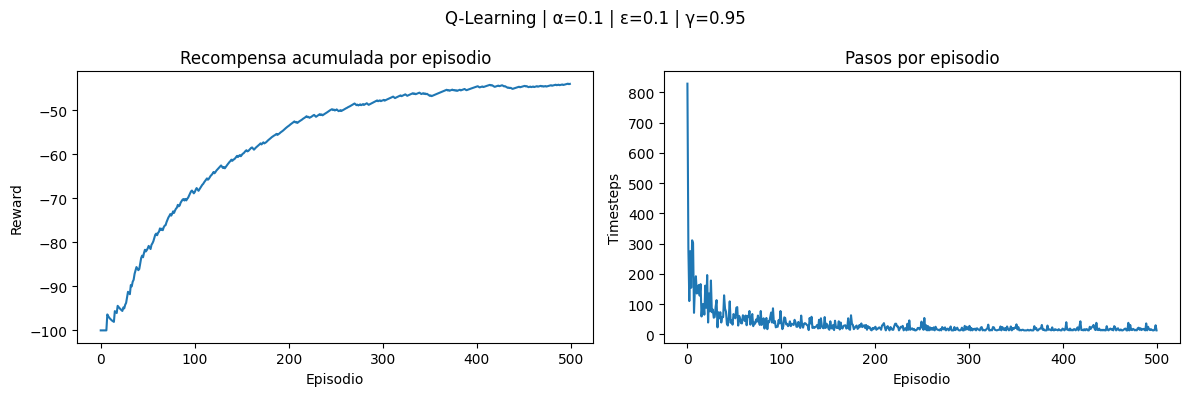

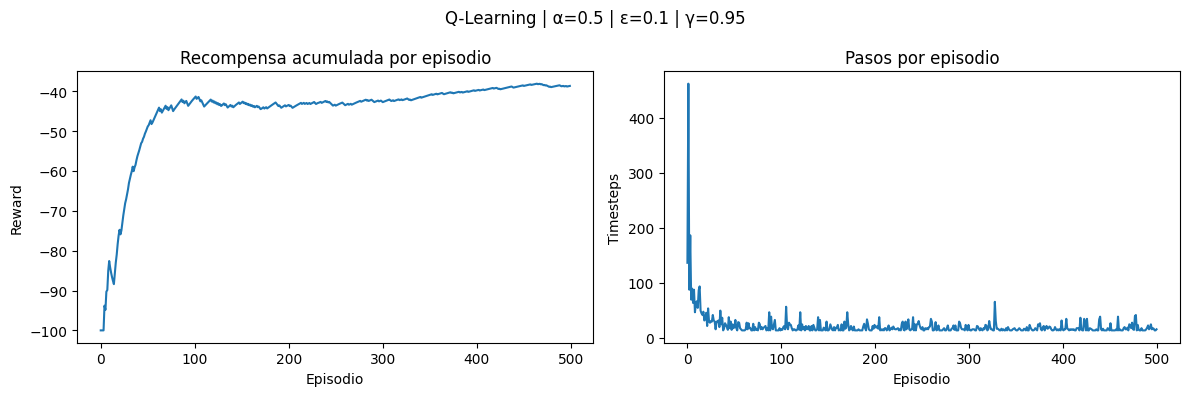

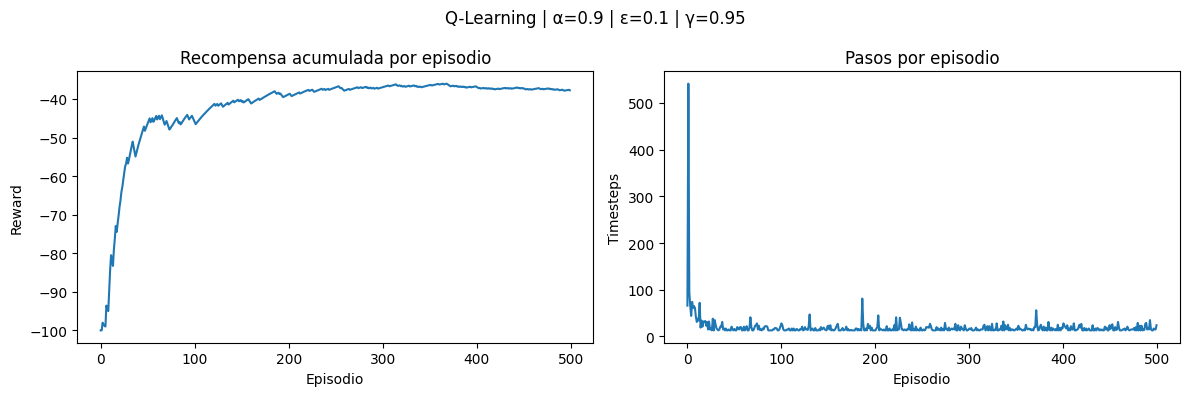

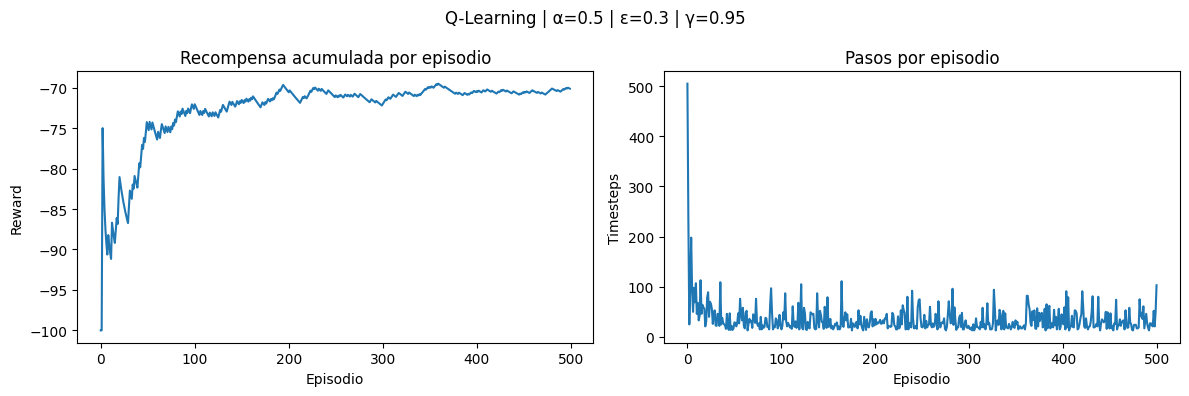

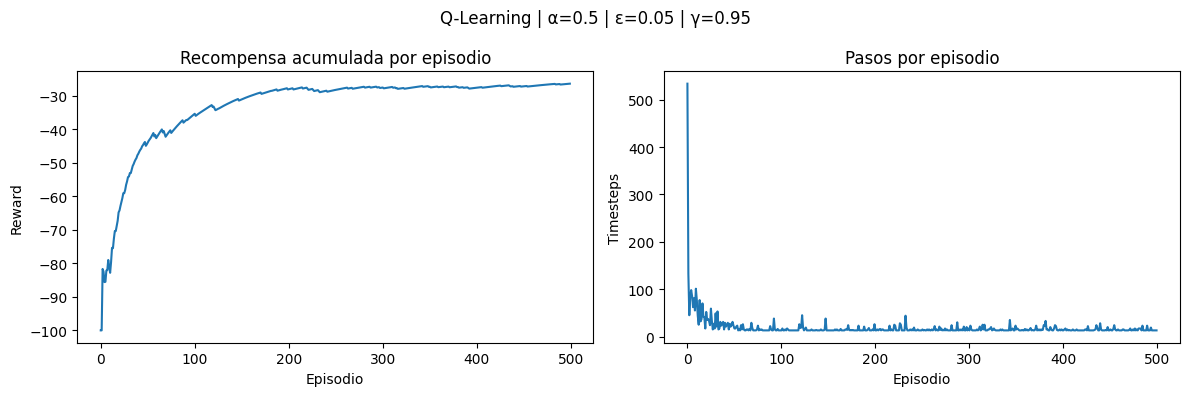

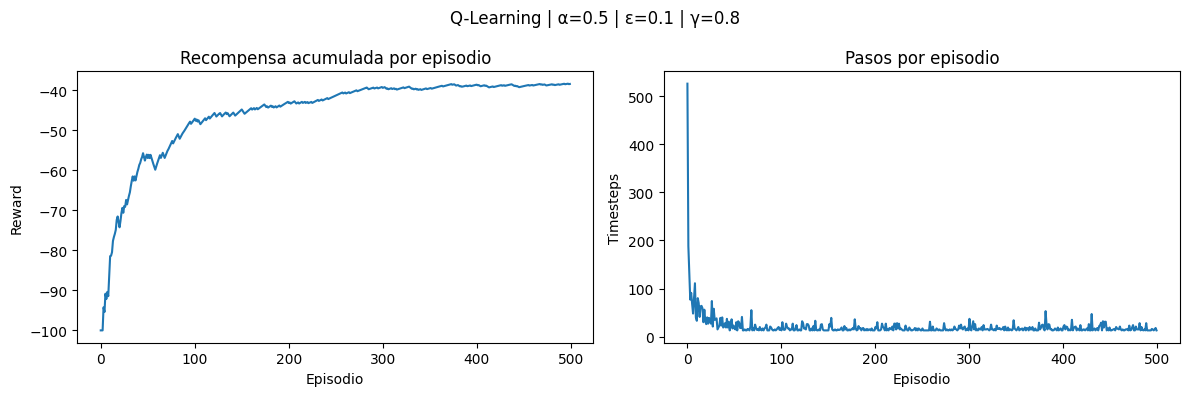

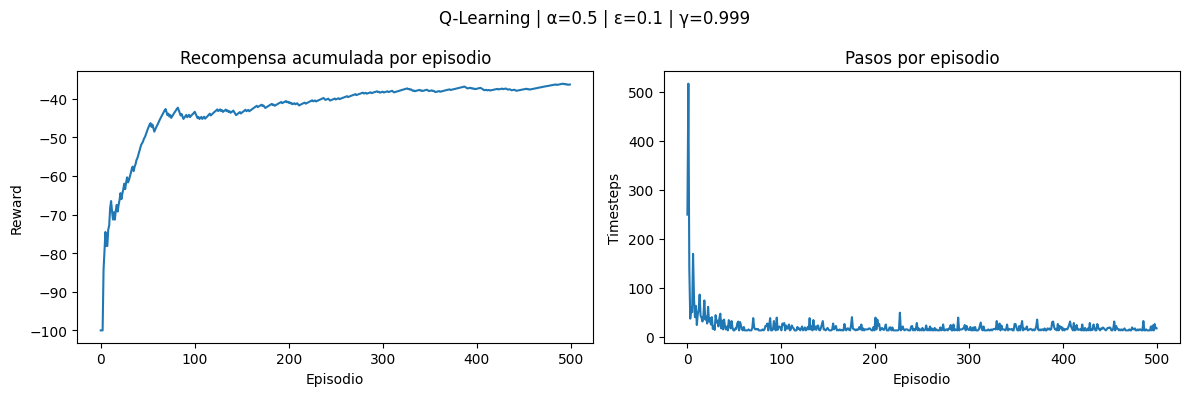

In [ ]:
for params in param_sets:
    # Reiniciar Q-table por corrida
    q = {}

    # Copia de params y, si es Q-Learning, añadir acciones
    params_full = dict(params)
    if "learn_Q_learning" in getattr(learning_function, "__name__", ""):
        params_full["actions"] = list(actions)

    avg, timesteps_ep, reward_ep = run(
        learning_function,
        params_full,
        episodes_to_run,
        env,
        actions,
        q,
        random_state,
    )

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_reward_per_episode_avg(reward_ep, axes[0])
    plot_steps_per_episode_line(timesteps_ep, axes[1])

    algo_name = "Q-Learning" if "learn_Q_learning" in getattr(learning_function, "__name__", "") else "SARSA"
    fig.suptitle(f"{algo_name} | α={params_full['alpha']} | ε={params_full['epsilon']} | γ={params_full['gamma']}")
    plt.tight_layout()
    plt.show()

Al barrer hiperparámetros se observaron tres patrones claros. Primero, la tasa de aprendizaje (α) marca el ritmo y la estabilidad: con α=0.1 el ascenso de la recompensa es más lento pero suave; con α=0.5 encuentro un buen equilibrio entre velocidad y estabilidad; con α=0.9 la curva sube rápido pero muestra oscilaciones y no mejora la media final frente a α=0.5. Segundo, la exploración (ε) es la palanca más determinante del rendimiento asintótico: con ε=0.3 la media se queda alta en timesteps y penalizada en recompensa por exploración persistente; con ε=0.05 la recompensa final mejora de forma visible (curva más alta y estable) y los pasos por episodio se reducen, señal de menos caídas esporádicas. Tercero, el descuento (γ) modula la preferencia por horizonte largo: γ=0.8 tiende a soluciones algo más miopes y rinde peor que el baseline; γ=0.999 mantiene una tendencia ascendente y alcanza una media final similar o ligeramente mejor, aunque con algo más de varianza en el camino.

En conjunto, estos resultados refuerzan la lectura previa del CliffWalking: Q-Learning converge hacia rutas cortas y riesgosas; por eso, reducir la exploración en régimen (ε más bajo) eleva la recompensa media al minimizar caídas residuales. A nivel práctico, de las combinaciones probadas, α≈0.5, ε≈0.05–0.1 y γ≈0.999 ofrecen el mejor compromiso entre velocidad de aprendizaje, estabilidad y recompensa asintótica.

In [ ]:
env.close()

## Conclusión de los dos métodos

Con los resultados obtenidos, Q-Learning y SARSA muestran el contraste clásico en CliffWalking. Q-Learning tiende a converger rápido hacia la ruta más corta y riesgosa, lo que reduce pasos pero deja una recompensa media peor cuando la exploración se mantiene fija (ε≈0.1), por las caídas residuales al acantilado. El barrido confirma que ε domina el desempeño asintótico (ε más bajo → menos caídas → media más alta), α regula rapidez vs estabilidad (α≈0.5 buen compromiso; α muy alto introduce oscilación), y γ alto (0.95–0.999) es razonable para este entorno de horizonte medio.

SARSA, en cambio, aprende políticas más seguras: la política final se aleja del borde, los timesteps se estabilizan y la recompensa media suele ser mejor que la de Q-Learning bajo ε fijo, justo porque SARSA evalúa lo que realmente ejecuta con exploración (on-policy) y penaliza las caídas durante el aprendizaje. Con ε constante SARSA ofrece el mejor promedio por su sesgo prudente. En síntesis: Q-Learning = eficiencia y ruta corta (riesgo si hay exploración), SARSA = robustez y ruta segura (mejor media con ε fijo); la elección depende de si se prioriza velocidad/óptimo o seguridad/estabilidad.